# 第7回講義 演習

In [1]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42

目次

課題. Variational auto-encoder (VAE)によるMNISTの画像生成

1. Variational auto-encoder (VAE)の実装
  - 1.1. MNISTデータセットの読み込み
  - 1.2. VAEの実装
  - 1.3. 学習
2. 再構成画像の可視化
  - 2.1. Original image
  - 2.2. Reconstruction image
3. 潜在変数からランダムサンプリング
4. 潜在空間の多様体の可視化

# 課題. Variational auto-encoder (VAE)によるMNISTの画像生成

## 1. Variational auto-encoder (VAE) の実装

### 1.1. MNISTデータセットの読み込み

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))])

batch_size = 100
device = 'cuda'
n_epochs = 15

dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable

9913344it [00:02, 4089080.95it/s]                             
Extracting ./data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

29696it [00:00, 169780.76it/s]                         
Extracting ./data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

1649664it [00:01, 1236656.11it/s]                             
Extracting ./data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

5120it [00:00, 5132609.10it/s]          
C:\Users\明朗\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can wr

### 1.2. VAEの実装

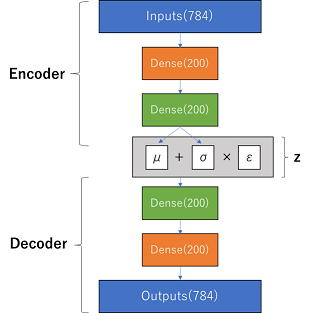

VAEのエンコーダとデコーダは、それぞれ次のように表されます。
- エンコーダ（ガウス分布）：$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}; \mu,\sigma^2{\bf I})$, ただし$\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x})$.
- デコーダ（ベルヌーイ分布）：$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}; \lambda)$, ただし$\lambda=f_{\theta}({\bf z})$.


また、VAEの下界（目的関数）は次のとおりです。

${\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = E_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]$

第1項が（負の）再構成誤差、第2項が正則化項に対応しています。

- 第1項は、次のように計算できます。

  $E_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})]=\frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})$,  ただし$ {\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}, \epsilon^{(l)}\sim N(0,{\bf I})$.

  なおデコーダはベルヌーイ分布なので、右辺は次のように計算できます。
  
  $\frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})=\frac{1}{L}\sum_{l=1}^L \sum_{i=1}^D x_i \log \lambda^{(l)}_i + (1-x_i)\log (1-\lambda^{(l)}_i)$,  ただし$\lambda^{(l)}=f_{\theta}({\bf z}^{(l)})$.  
  （実装内の`reconstruction`に対応、簡単のため今回の演習では$L=1$を採用）


- また第2項については、次のように解析的に計算できます（ただし、$p_{\theta}({\bf z})={\cal N}(0,{\bf I})$とする）。
  $D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})] = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j)^2)-(\mu_j)^2-(\sigma_j)^2)$  
  （実装内の`KL`に対応）

In [4]:
# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))


class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        var = F.softplus(self.dense_encvar(x))
        return mean, var

    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape).to(device)
        return mean + torch.sqrt(var) * epsilon

    def _decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        x = torch.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        x = self._decoder(z)
        return x, z

    def loss(self, x):
        mean, var = self._encoder(x)
        # KL lossの計算
        KL = -0.5*torch.mean(torch.sum(1 + torch_log(var) - mean**2 - var, dim=1)) # WRITE ME

        z = self._sample_z(mean, var)
        y = self._decoder(z)

        # reconstruction lossの計算(今回はL=1)
        reconstruction = torch.mean(torch.sum(x*torch_log(y) + (1-x)*torch_log(1-y), dim=1)) # WRITE ME

        return KL, -reconstruction 

### 1.3. 学習

In [5]:
z_dim = 10
model = VAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        model.zero_grad()

        y = model(x)  # VAEの出力を得る

        KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算

        loss = KL_loss + reconstruction_loss  # 和を取ってlossとする

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x, t in dataloader_valid:

        x = x.to(device)

        y = model(x)

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))

EPOCH:1, Train Lower Bound:185.259308, (6.172165, 179.087158), Valid Lower Bound:149.006027
EPOCH:2, Train Lower Bound:137.967102, (11.730073, 126.237030), Valid Lower Bound:131.740265
EPOCH:3, Train Lower Bound:126.792862, (13.460938, 113.331924), Valid Lower Bound:122.950752
EPOCH:4, Train Lower Bound:120.790756, (14.502216, 106.288536), Valid Lower Bound:119.190987
EPOCH:5, Train Lower Bound:117.511696, (15.107715, 102.403984), Valid Lower Bound:116.165794
EPOCH:6, Train Lower Bound:114.871277, (15.793268, 99.078011), Valid Lower Bound:114.156700
EPOCH:7, Train Lower Bound:113.041878, (16.120798, 96.921082), Valid Lower Bound:112.426720
EPOCH:8, Train Lower Bound:111.806122, (16.330383, 95.475739), Valid Lower Bound:112.491379
EPOCH:9, Train Lower Bound:110.800690, (16.485548, 94.315140), Valid Lower Bound:111.135536
EPOCH:10, Train Lower Bound:110.018921, (16.615774, 93.403137), Valid Lower Bound:110.249847
EPOCH:11, Train Lower Bound:109.301247, (16.691668, 92.609581), Valid Lower

## 2. 再構成画像の可視化

### 2.1. Original image

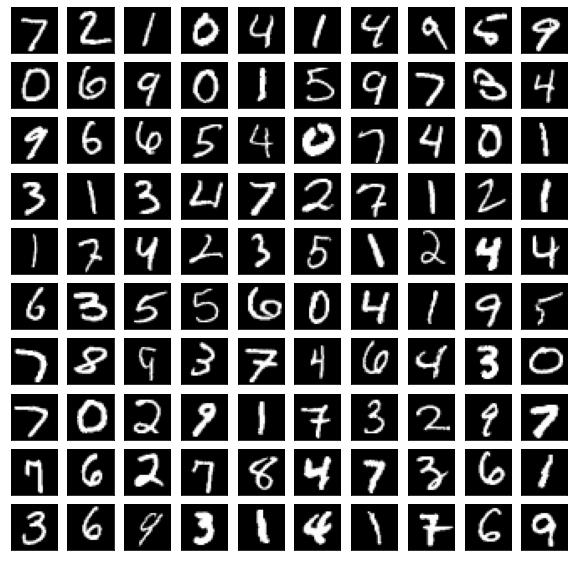

In [6]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

### 2.2. Reconstruction image

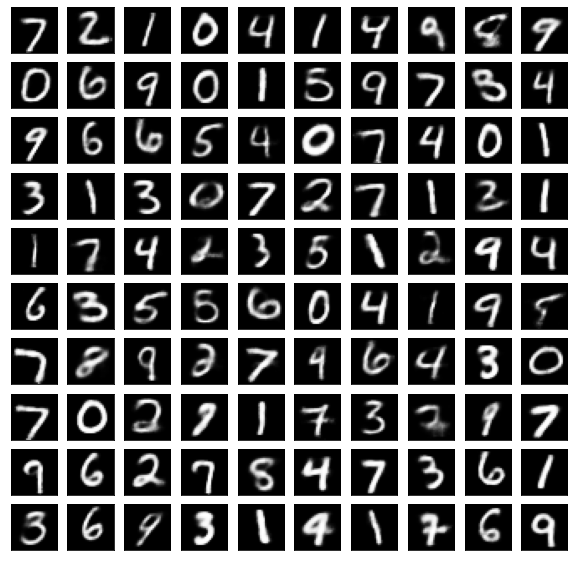

In [7]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y, z = model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## 3. 潜在変数からランダムサンプリング

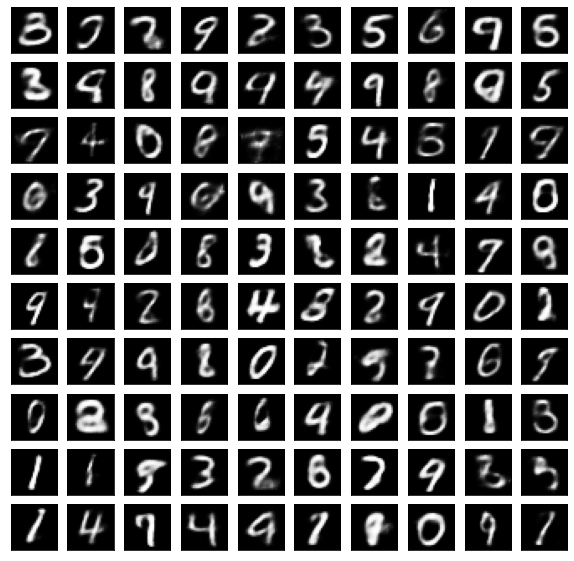

In [8]:
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    z = torch.randn([1, z_dim]).to(device)
    y = model._decoder(z)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## 4. 潜在空間の多様体の可視化

- データ間を遷移して、潜在空間で多様体構造が学習できていることを確認しましょう。

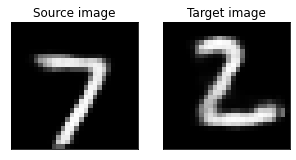

In [11]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(5, 5))
model.eval()

x0, t = valid_dataset[0]
x0 = x0.to(device)
x0 = x0.unsqueeze(0)
y0, z0 = model(x0)
im = y0.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
ax0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax0.set_title('Source image')
ax0.imshow(im, 'gray')

x1, t = valid_dataset[1]
x1 = x1.to(device)
x1 = x1.unsqueeze(0)
y1, z1 = model(x1)
im = y1.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Target image')
ax1.imshow(im, 'gray')

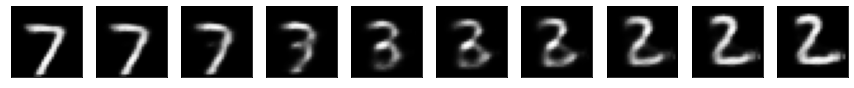

In [12]:
fig = plt.figure(figsize=(15, 15))
z_linear = torch.cat([z1 * (i * 0.1) + z0 * ((9 - i) * 0.1) for i in range(10)])
z_linear = z_linear.view((10, -1))
y2 = model._decoder(z_linear).view(-1, 28, 28)
for i, im in enumerate(y2.cpu().detach().numpy()):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')